# Airbnb-AI
A ml-project to predict rent of an airbnb flat in Barcelona
Nils Liebrand, Till Malte Friedrich, Than Tran

In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')
import requests
import unicodedata
from PIL import Image
from io import BytesIO
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import zipfile
import ast
import matplotlib.pyplot as plt
import geopandas as gpd
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/calendar.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._reviews.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._listings_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.geojson
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._neighbourhoods.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._listings.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._neighbourhoods.geojson
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._calendar.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._reviews_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews_2.csv


# Extracing the data

In [24]:
listing_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings.csv', encoding="latin1")
listing_details_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings_2.csv' , encoding="latin1")
review_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews.csv' , encoding="latin1")
geo_data = gpd.read_file('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.geojson')


In [ ]:
#visualizing the data
def plotData(information = 'price', vmax = 300):
    #longitudes = listing_data["longitude"]
    #latitudes = listing_data["latitude"]
    data = listing_data[information].astype(float)

    mask = data != 0
    filtered_data = data[mask]
    filtered_lons = listing_data["longitude"][mask]
    filtered_lats = listing_data["latitude"][mask]
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_data.plot(ax=ax, color='lightgrey', edgecolor='white')
    
    sc = ax.scatter(
        filtered_lons,
        filtered_lats,
        c=filtered_data,
        cmap='RdYlGn_r',
        s=4,
        vmin=0,
        vmax=vmax,
        alpha=0.4
    )
    
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(information)
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    
    ax.set_title(information + " and location of Airbnbs in Barcelona")
    plt.tight_layout()
    plt.show()

plotData()

## Processing the data

In [25]:
#listings
#remove unnecessary data
columns_to_remove = ['listing_url', 'scrape_id', 'host_url', 'host_id', 'host_thumbnail_url' ,  'last_scraped', 'source', 'bathrooms_text', 'calendar_updated', 'calendar_last_scraped']
listing_details_data = listing_details_data.drop(columns=columns_to_remove)
listing_data = listing_data.drop(columns=['host_id'])

In [26]:
#find dublicates
column_names = listing_data.columns.tolist()
for column in column_names:
    
    if column in listing_details_data.columns.tolist():
        listing_details_data = listing_details_data.drop(columns = column)
        
listing_data = pd.concat([listing_data, listing_details_data], axis=1)

In [27]:

        

#reviews
#remove unnecessary data
columns_to_remove = ['reviewer_id', "id", "reviewer_name", "date"]
review_data = review_data.drop(columns = columns_to_remove)

print(listing_data[:5])
print(review_data[:5])


      id                                               name       host_name  \
0  18674    Huge flat for 8 people close to Sagrada Familia   Mireia  Maria   
1  23197  Forum CCIB DeLuxe, Spacious, Large Balcony, relax  Etain (Marnie)   
2  32711                  Sagrada Familia area - CÃ²rsega 1            Nick   
3  34241   Stylish Top Floor Apartment - Ramblas Plaza Real          Andres   
4  34981               VIDRE HOME PLAZA REAL on LAS RAMBLAS          Andres   

  neighbourhood_group                        neighbourhood   latitude  \
0            Eixample                  la Sagrada FamÃ­lia  41.405560   
1         Sant MartÃ­               el BesÃ²s i el Maresme  41.412432   
2             GrÃ cia  el Camp d'en Grassot i GrÃ cia Nova  41.405660   
3        Ciutat Vella                      el Barri GÃ²tic  41.380620   
4        Ciutat Vella                      el Barri GÃ²tic  41.379780   

   longitude        room_type  price  minimum_nights  ...  \
0    2.17262  Entire home

## Handle Nan data

In [28]:
#Nan handling
for column in listing_data.columns.tolist():
    isString = False
    isNumerical = False
    isCategorial = False
    for x in listing_data[column]:
        if type(x) == str:
            isString = True
            print(f"replaced_str: {column}")
            break
        elif type(x) == float or type(x) == int:
            if x > 1:
                isNumerical = True
                print(f"replaced_numerical: {column}")
            break
        elif type(x) == float or type(x) == int:
            if x in [0,1]:
                isCategorial = True
                print(f"replaced_categorial: {column}")
    
    if isString:
        listing_data[column].replace('nan', '')
        
    if isNumerical:
        listing_data[column].replace('nan', 0)

    if isCategorial:
        listing_data[column].replace('nan', 0)
        


for column in listing_data.columns:
    col_type = listing_data[column].dtype
    
    if pd.api.types.is_string_dtype(col_type):
        listing_data[column] = listing_data[column].fillna('')
    elif pd.api.types.is_numeric_dtype(col_type):
        unique_vals = listing_data[column].dropna().unique()
        if set(unique_vals).issubset({0, 1}):
            listing_data[column] = listing_data[column].fillna(0)
        else:
            listing_data[column] = listing_data[column].fillna(0)
    else:
        listing_data[column] = listing_data[column].fillna('')
                
            

replaced_numerical: id
replaced_str: name
replaced_str: host_name
replaced_str: neighbourhood_group
replaced_str: neighbourhood
replaced_numerical: latitude
replaced_numerical: longitude
replaced_str: room_type
replaced_numerical: price
replaced_numerical: number_of_reviews
replaced_str: last_review
replaced_numerical: calculated_host_listings_count
replaced_numerical: availability_365
replaced_numerical: number_of_reviews_ltm
replaced_str: license
replaced_str: description
replaced_str: neighborhood_overview
replaced_str: picture_url
replaced_str: host_since
replaced_str: host_location
replaced_str: host_about
replaced_str: host_response_time
replaced_str: host_response_rate
replaced_str: host_acceptance_rate
replaced_str: host_is_superhost
replaced_str: host_picture_url
replaced_str: host_neighbourhood
replaced_numerical: host_listings_count
replaced_numerical: host_total_listings_count
replaced_str: host_verifications
replaced_str: host_has_profile_pic
replaced_str: host_identity_ve

## Handling categorial and image data

In [29]:



#expanding listing data amenities list into inidividual rows
cat_dict = {}
for listing in listing_data["amenities"]:
    listing = listing.replace('[]"', '').replace("[", "").replace("]", "").replace('"', '')
    listing = listing.split(',')
    for x in listing:
        x = x.strip().lower()
        if x in cat_dict:
            cat_dict[x] += 1
        else:
            cat_dict[x] = 1


#take 100 most frequent categories
top_amenities = sorted(cat_dict.items(), key=lambda x: x[1], reverse=True)[:100]
relevant_categories = [cat for cat, _ in top_amenities]
    

def encode_amenities(amenity_str):
    amenities = amenity_str.replace('[]"', '').replace("[", "").replace("]", "").replace('"', '')
    amenity_list = [a.strip().lower() for a in amenities.split(',')]
    row = {}
    for category in relevant_categories:
        row["amenity_" + category] = int(any(category in a for a in amenity_list))
    return row
    

encoded_df = listing_data["amenities"].apply(encode_amenities).apply(pd.Series)
encoded_df.columns = [col.replace(" ", "_") for col in encoded_df.columns]
listing_data = pd.concat([listing_data, encoded_df], axis=1)
listing_data = listing_data.drop(columns='amenities')

print(listing_data[:5])


      id                                               name       host_name  \
0  18674    Huge flat for 8 people close to Sagrada Familia   Mireia  Maria   
1  23197  Forum CCIB DeLuxe, Spacious, Large Balcony, relax  Etain (Marnie)   
2  32711                  Sagrada Familia area - CÃ²rsega 1            Nick   
3  34241   Stylish Top Floor Apartment - Ramblas Plaza Real          Andres   
4  34981               VIDRE HOME PLAZA REAL on LAS RAMBLAS          Andres   

  neighbourhood_group                        neighbourhood   latitude  \
0            Eixample                  la Sagrada FamÃ­lia  41.405560   
1         Sant MartÃ­               el BesÃ²s i el Maresme  41.412432   
2             GrÃ cia  el Camp d'en Grassot i GrÃ cia Nova  41.405660   
3        Ciutat Vella                      el Barri GÃ²tic  41.380620   
4        Ciutat Vella                      el Barri GÃ²tic  41.379780   

   longitude        room_type  price  minimum_nights  ...  \
0    2.17262  Entire home

In [ ]:
plotData("amenity_free_street_parking",1)


## Format data in cells

In [30]:
#latin1 to closest ascii character
def to_ascii(text):
    if not isinstance(text, str):
        return text  
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')

column_names = listing_data.columns.tolist()
for column in column_names:
    if column not in ["host_picture_url", "picture_url"]: #Dont mess with links
        listing_data[column] = listing_data[column].apply(to_ascii)

column_names = review_data.columns.tolist()
for column in column_names:
    review_data[column] = review_data[column].apply(to_ascii)

print(listing_data.head())
print(review_data.head())

      id                                               name       host_name  \
0  18674    Huge flat for 8 people close to Sagrada Familia   Mireia  Maria   
1  23197  Forum CCIB DeLuxe, Spacious, Large Balcony, relax  Etain (Marnie)   
2  32711                  Sagrada Familia area - CA2rsega 1            Nick   
3  34241   Stylish Top Floor Apartment - Ramblas Plaza Real          Andres   
4  34981               VIDRE HOME PLAZA REAL on LAS RAMBLAS          Andres   

  neighbourhood_group                        neighbourhood   latitude  \
0            Eixample                   la Sagrada FamAlia  41.405560   
1          Sant MartA               el BesA2s i el Maresme  41.412432   
2             GrA cia  el Camp d'en Grassot i GrA cia Nova  41.405660   
3        Ciutat Vella                      el Barri GA2tic  41.380620   
4        Ciutat Vella                      el Barri GA2tic  41.379780   

   longitude        room_type  price  minimum_nights  ...  \
0    2.17262  Entire home

In [31]:

#license only relevant if true or false
listing_data['license'] = listing_data['license'].apply(lambda x: 1 if pd.notna(x) else 0)
#for column in listing_data.columns.tolist():
#print(listing_data.columns.tolist())   
print(len(listing_data.columns.tolist()))


169


In [32]:
#extracting categories
category_dict = {}
category_data_columns = ['neighbourhood_group', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'room_type', 'host_location', 'host_neighbourhood', 'host_response_time', 'property_type']
for column in category_data_columns:
    column_categories = []
    for x in listing_data[column]:
        if x not in column_categories:
            column_categories.append(x)
    category_dict[column] = column_categories
category_dict

#license only relevant if true or false
listing_data['license'] = listing_data['license'].apply(lambda x: 1 if pd.notna(x) else 0)
#print(listing_data.columns.tolist())   

## t, f to 0, 1
for category in listing_data.columns.tolist():
    if 't' in listing_data[category].tolist() and 'f' in listing_data[category].tolist():
        print(category)
        listing_data[category] = listing_data[category].apply(lambda x: 1 if x == 't' else 0)
        print(listing_data[category].head())

#print(category_dict)

# One-hot encoding for categorical columns
for column in category_data_columns:
    # Get unique categories for this column
    unique_categories = category_dict[column]


    
    # Create dummy variables for each category
    for category in unique_categories:
        cat_name = str(category).replace(' ', '_').replace(',','').lower()
        listing_data[f'{column}_{cat_name}'] = (listing_data[column] == category).astype(int)
    
    listing_data.drop(column, axis=1, inplace=True)

#handle host verifications
verificat_list = []
for listing in listing_data["host_verifications"]:
    listing = str(listing).replace('[]"', '').replace("[", "").replace("]", "").replace('"', '')
    listing = listing.split(',')
    for x in listing:
        x = x.strip().lower()
        if x not in verificat_list:
            verificat_list.append(x)

def encode_verifications(verifications_str):
    verifications = str(verifications_str).replace('[]"', '').replace("[", "").replace("]", "").replace('"', '')
    verifications_list = [v.strip().lower() for v in verifications.split(',')]
    row = {}
    categories = []
    
    for category in verificat_list:
        row["verificaions_" + category] = int(any(category in a for a in verifications_list))
    return row
    

encoded_df = listing_data["host_verifications"].apply(encode_verifications).apply(pd.Series)
encoded_df.columns = [col.replace(" ", "_") for col in encoded_df.columns]
listing_data = pd.concat([listing_data, encoded_df], axis=1)
listing_data = listing_data.drop(columns='host_verifications')


host_is_superhost
0    0
1    0
2    0
3    0
4    0
Name: host_is_superhost, dtype: int64
host_has_profile_pic
0    1
1    1
2    1
3    1
4    1
Name: host_has_profile_pic, dtype: int64
host_identity_verified
0    1
1    1
2    1
3    1
4    1
Name: host_identity_verified, dtype: int64
has_availability
0    1
1    1
2    1
3    1
4    1
Name: has_availability, dtype: int64
instant_bookable
0    1
1    0
2    0
3    0
4    0
Name: instant_bookable, dtype: int64


0    1
1    1
2    1
3    0
4    1
Name: property_type_entire_rental_unit, dtype: int64


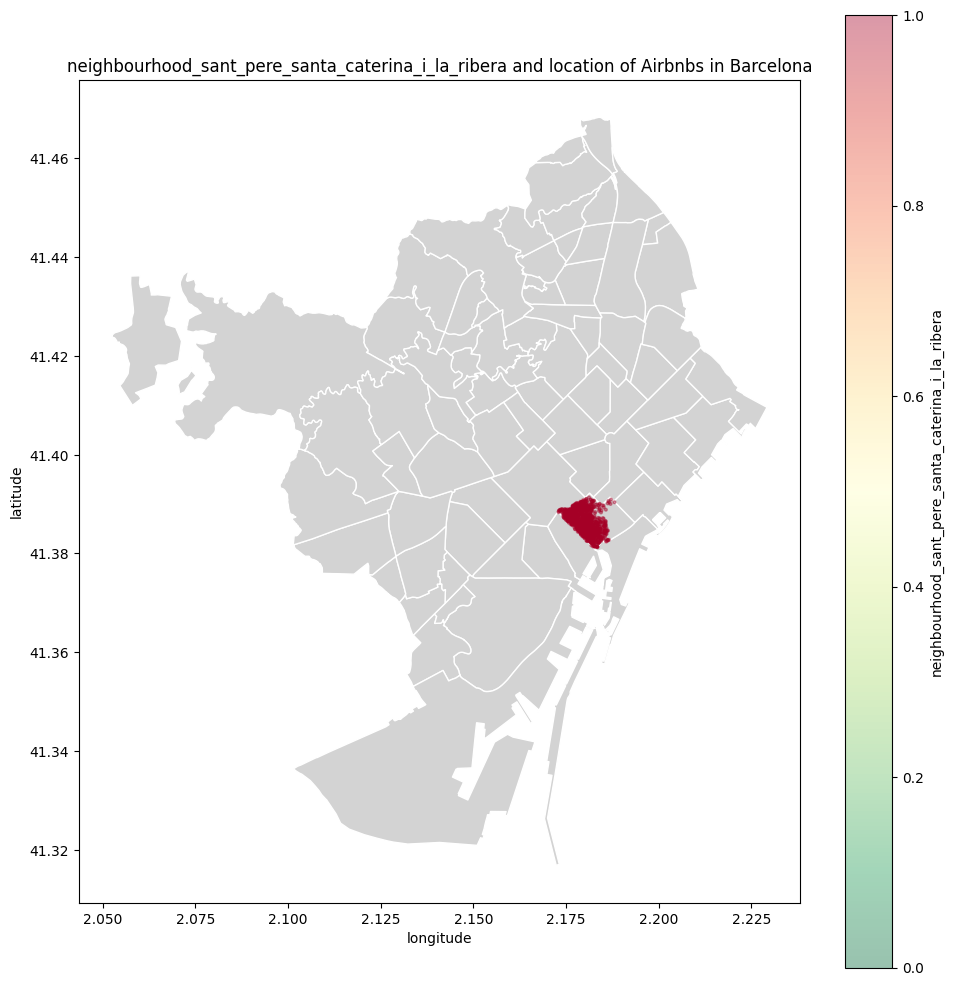

In [33]:
print(listing_data['property_type_entire_rental_unit'].head())
plotData("neighbourhood_sant_pere_santa_caterina_i_la_ribera",1)

In [34]:
print(listing_data["picture_url"][100])
print(listing_data["host_picture_url"][0])

https://a0.muscache.com/pictures/hosting/Hosting-U3RheVN1cHBseUxpc3Rpbmc6MTk2MDIx/original/1388c2ff-321b-4191-a8f5-76e3781e8a48.jpeg
https://a0.muscache.com/im/pictures/user/User-71615/original/ef6beed8-ebe5-4ab3-9798-11fd00a07a6f.jpeg?aki_policy=profile_x_medium


In [35]:

#Date to numerical
#put day, month, year in seperate columns
#listing_data
date_columns = ['last_review', 'host_since', 'first_review']
#for col in listing_data.columns.tolist():
    #print(col + " : " + str(listing_data[col][0]))


last_review_rows = {"last_review_day" : [], "last_review_month" : [], "last_review_year" : []}
host_since_rows = {"host_since_day" : [], "host_since_month" : [], "host_since_year" : []}
first_review_rows = {"first_review_day" : [], "first_review_month" : [], "first_review_year" : []}


for column in date_columns:
    for x in listing_data[column]:
        row = [0,0,0]
        if type(x) != float and x != '':
            row = x.split('-')
            row = [int(r) for r in row]
        #date is in american format !!!
        if column == "last_review":
            last_review_rows["last_review_day"].append(row[2])
            last_review_rows["last_review_month"].append(row[1])                
            last_review_rows["last_review_year"].append(row[0])
        if column == "host_since":
            host_since_rows["host_since_day"].append(row[2])
            host_since_rows["host_since_month"].append(row[1])                
            host_since_rows["host_since_year"].append(row[0])
        if column == "host_since":
            first_review_rows["first_review_day"].append(row[2])
            first_review_rows["first_review_month"].append(row[1])                
            first_review_rows["first_review_year"].append(row[0])
            
        
        
last_review_dates = pd.DataFrame.from_dict(last_review_rows)
host_since_dates = pd.DataFrame.from_dict(host_since_rows)
first_review_dates = pd.DataFrame.from_dict(first_review_rows)
print(last_review_dates.head())
print(host_since_dates.head())
print(first_review_dates.head())

listing_data = pd.concat([listing_data, last_review_dates, host_since_dates, first_review_dates], axis = 1)
listing_data.drop(columns=date_columns, inplace=True)
print(listing_data)

   last_review_day  last_review_month  last_review_year
0               16                  9              2024
1                3                  1              2025
2                4                  3              2025
3                5                 11              2024
4                2                  2              2025
   host_since_day  host_since_month  host_since_year
0              19                 1             2010
1               9                 3             2010
2              31                 5             2010
3              24                 1             2010
4              24                 1             2010
   first_review_day  first_review_month  first_review_year
0                19                   1               2010
1                 9                   3               2010
2                31                   5               2010
3                24                   1               2010
4                24                   1            

In [ ]:
#Add Image links
#f'/kaggle/working/{directory}/{filename}.jpg

In [36]:
#Remove %
#dont mess with links
cols_to_clean = listing_data.columns.difference(['picture_url', 'host_picture_url'])
listing_data[cols_to_clean] = listing_data[cols_to_clean].replace('%', '', regex=True)


In [ ]:
listing_data["host_response_rate"]

In [37]:
import string
#listing_data
#Text to TF-IDF encoding
#for col in listing_data.columns.tolist():
#    print(col + " : " + str(listing_data[col][0]))

text_columns = ["name", "description", "neighborhood_overview", "host_about", "host_name"]
#for column in text_columns:

def remove_punctuation(text):
    if isinstance(text, str):
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)
    else:
        return text



#extract word frequencies
def getWordFrequencies(column, df = listing_data):
    word_frequencies = {}
    for row in df[column]:
        if type(row) != str:
            continue
        words = remove_punctuation(row).split(' ')
        words = [w.lower() for w in words]
        for x in words:
            if x not in word_frequencies:
                word_frequencies[x] = 1
            else:
                word_frequencies[x] += 1

    return word_frequencies

#clean filler words and single letters
def cleanToShortWords(word_frequencies, minlen = 3):
    keysToRemove = []
    for x in word_frequencies:
        if len(x) < minlen:
            keysToRemove.append(x)
    for x in keysToRemove:
        word_frequencies.pop(x, None)



#returns a dataframe that indicates word frequencies
#input: the number of words to track(int this case 150 most relevant ones)
def getWordFreqDataFrame(column, first_word_to_track = 0, size = 150, minlen=3, df = listing_data):
    freq = getWordFrequencies(column, df)
    cleanToShortWords(freq, minlen)
    #extract column names
    sorted_items = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    top_categories = [key for key, _ in sorted_items[first_word_to_track:size]]

    word_dict = dict((column + "_word_freq_" + cat,df.shape[0] * [0]) for cat in top_categories)
    
    for i in range(df.shape[0]):
    #for row in listing_data[column]:
        row = df[column][i]
        if type(row) != str:
            continue
        for x in top_categories:
            if x in row.lower():
                word_dict[column + "_word_freq_" + x][i] += 1
                if word_dict[column + "_word_freq_" + x][i] > 1:
                    print("that actually happens never :)")

    return pd.DataFrame.from_dict(word_dict)
    

for col in text_columns:
    df = getWordFreqDataFrame(col)
    listing_data = pd.concat([listing_data, df], axis=1)

listing_data.drop(columns = text_columns, inplace=True)




In [38]:
#reviews 
#Text to TF-IDF encoding
text_columns = ["comments"]
for col in text_columns:
    df = getWordFreqDataFrame(col, first_word_to_track = 4, size = 300, df = review_data)
    review_data = pd.concat([review_data, df], axis=1)
review_data.drop(columns = text_columns, inplace=True)

In [39]:
review_data

,listing_id,comments_word_freq_apartment,comments_word_freq_great,comments_word_freq_for,comments_word_freq_with,comments_word_freq_location,comments_word_freq_stay,comments_word_freq_place,comments_word_freq_you,comments_word_freq_barcelona,...,comments_word_freq_iii,comments_word_freq_large,comments_word_freq_such,comments_word_freq_airport,comments_word_freq_sure,comments_word_freq_modern,comments_word_freq_find,comments_word_freq_floor,comments_word_freq_sur,comments_word_freq_outside
0,18674,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18674,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18674,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18674,1,0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,18674,1,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965850,1354363590227566368,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
965851,1354420227523365801,1,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
965852,1354420227523365801,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
965853,1354420227523365801,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Download Images

In [ ]:
#downloading the images
#DO NOT RUN AGAIN - THE IMAGES ARE ALREADY DOWNLOADED AND STORED IN /kaggle/working
os.makedirs('/kaggle/working/picture_url_128x128', exist_ok=True)
os.makedirs('/kaggle/working/host_picture_url_128x128', exist_ok=True)

def download_and_resize(url, filename, directory, size=(128, 128)):
    try:
        # Download image
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        
        # Open image
        img = Image.open(BytesIO(response.content))
        
        # Handle alpha channel if exists
        if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
            background = Image.new('RGB', img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[-1])  # Use alpha channel as mask
            img = background
        
        # Convert to RGB if not already (for CMYK, L, etc.)
        elif img.mode != 'RGB':
            img = img.convert('RGB')
            
        # Resize and save
        img = img.resize(size, Image.Resampling.LANCZOS)
        img.save(f'/kaggle/working/{directory}/{filename}.jpg', 'JPEG', quality=85)
        return True
        
    except Exception as e:
        print(f"Failed to process {url}: {str(e)}")
        return False

# Process all images (adjust batch size as needed)
for i, row in listing_data.iterrows():
    download_and_resize(row['picture_url'], f"image_{row['id']}", "picture_url_128x128")
    download_and_resize(row['host_picture_url'], f"image_{row['id']}", "host_picture_url_128x128")

listing_data.drop(columns=["host_picture_url", "picture_url"], inplace=True)

In [40]:
#collaps word frequencies in reviews and merge to listing_data
#review_data
review_data = review_data.groupby('listing_id').sum()
print(review_data.shape)
print(listing_data.shape)


review_data = review_data.reset_index().rename(columns = {'listing_id': 'id'})

print(review_data.head())

listing_data = pd.merge(listing_data, review_data, on='id', how='outer')

(14513, 296)
(19422, 1686)
      id  comments_word_freq_apartment  comments_word_freq_great  \
0  18674                            17                        13   
1  23197                            41                        30   
2  32711                            23                        33   
3  34241                            12                        10   
4  34981                            94                       103   

   comments_word_freq_for  comments_word_freq_with  \
0                      13                       10   
1                      38                       23   
2                      30                       17   
3                      13                       10   
4                     117                       71   

   comments_word_freq_location  comments_word_freq_stay  \
0                           17                        6   
1                           15                       32   
2                           35                       22   
3  

In [45]:
#replace new nans
for column in listing_data.columns.tolist():
    if 'comments_word_freq' in column:
        listing_data[column].replace(np.nan, 0.0, inplace=True)

#listing_data.drop(columns = ["id"], inplace = True)
listing_data

,id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,...,comments_word_freq_iii,comments_word_freq_large,comments_word_freq_such,comments_word_freq_airport,comments_word_freq_sure,comments_word_freq_modern,comments_word_freq_find,comments_word_freq_floor,comments_word_freq_sur,comments_word_freq_outside
0,18674,41.405560,2.172620,179.0,1,45,0.31,29,147,5,...,0.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,3.0,4.0
1,23197,41.412432,2.219750,251.0,3,82,0.48,1,0,8,...,0.0,10.0,0.0,0.0,1.0,5.0,1.0,1.0,5.0,7.0
2,32711,41.405660,2.170150,104.0,1,143,0.86,3,107,31,...,1.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,7.0,0.0
3,34241,41.380620,2.175170,157.0,31,25,0.14,3,327,15,...,0.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,3.0
4,34981,41.379780,2.176230,401.0,5,256,1.46,3,191,34,...,1.0,12.0,2.0,2.0,11.0,5.0,6.0,4.0,16.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19417,1368830368483840080,41.387100,2.171690,69.0,1,0,0.00,14,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19418,1368842600507596138,41.396902,2.175337,68.0,32,0,0.00,29,365,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19419,1368857282499600549,41.394700,2.163284,206.0,31,0,0.00,483,329,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19420,1368915429723272105,41.378330,2.163580,92.0,1,0,0.00,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
#Make numerical 
#listing_data.drop(columns=["host_picture_url", "picture_url"], inplace=True)
listing_data.replace("", 0, inplace=True)
listing_data = listing_data.astype(float)

In [53]:
#Dataframe
listing_data.to_csv('/kaggle/working/listing_data.csv', index = False)
#review_data.to_csv('/kaggle/working/review_data.csv', index = False)

# Train the model
### Linear Regression